# Topic 5 -- Advanced Optimizations

Welcome back! in the previous topic, you learned how Neural Networks are formed by **stacking** Logistic Regression layers on top of one another, creating a construct that can learn **much more complicated hypothesis functions**. While this allows you to tackle more challenging problems such as basic computer vision, having so many $w$ and $b$ parameters mean Neural Networks **take much longer to train** and are **prone to overfitting**.

In this notebook, we are going to cover various optimization techniques that can **dramatically speed up learning**, as well as advanced methods to **address overfitting**. Later on, we are going to revisit our **handwritten digits classifier** and see if we can **improve its performance** with our new knowledge.

## Table of Contents

1. [Big Data](#bigdata)
    - [Stochastic Gradient Descent](#sgd)
    - [Mini-Batch Gradient Descent](#minibatch)
    
    
2. [Coding Exercise: Data Generator](#datagen)
    - [Getting Familiar with `yield`](#yield)
    - [Data Generator](#gen)
 
 
3. [Weight Initialization](#weights)
    - [Why do we Need to Initialize the Weights Randomly?](#whyrandweights)
 
 
    
4. [Dropout](#dropout)
    - [A New Form of Regularization](#newreg)
    - [Implementation in PyTorch](#dppy)
    
    
5. [Feature Scaling II](#feat2)
    - [Batch Normalization](#batchnorm)
    - [Where to place Batch Norm](#where)
    
    
6. [Optimizers](#optimizers)
    - [Momentum](#momentum)
    - [RMSprop](#rmsprop)
    - [Adam](#adam)
    
    
7. [Hyperparameter Search](#hparams)
    - [The General Idea](#idea)
    - [Grid Search](#grid)

### Before we Begin...

Let's first import our modules as always. The modules used in this notebook the same as the ones used previously.

- **Numpy**: Powerful linear algebra library
- **Pandas**: Used for organizing our data
- **SKLearn**: Abstract machine learning library
- **MatPlotLib, Bokeh,** and **SeaBorn**: Data visualization libraries
- **utils.py**: A custom python script that contains functions used in this course.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from utils import *

## Big Data <a name="bigdata"></a>

Up until now, when training a learning algorithm, whether it's simple Linear/Logistic Regression or it's a Neural Network, we trained it by passing the **entire dataset** at once. The act of training a ML algorithm by iterating over the entire training dataset at once is called **Batch Gradient Descent**.

For now, batch gradient descent has worked for our purposes, however, there are two main issues when we mention batch gradient descent in the context of Neural Networks. **Firstly**, batch gradient descent is **slow** -- you need to make one pass over the **entire training set** before making **one gradient descent step**. The **second**, and more important issue is that often times in Deep Learning, we need to use datasets that are **massive** -- sometimes over 100,000 hi-res images can be used to train a Deep Neural Net. A computer simply **does not have enough memory** to load in that big of a dataset.

### Stochastic Gradient Descent <a name="sgd"></a>

**Stochastic Gradient Descent** or **SGD** is probably something you have seen before. In our PyTorch portions of the course, we've used the `SGD()` optimizer to perform gradient descent on our cost function. <u>To make things clear, we used `SGD` to perform **Batch Gradient Descent** on all of our projects so far</u>, however, the formal concept of SGD is actually quite the opposite of batch gradient descent. Instead of feeding forward the entire training set and then updating the weights and biases, SGD will **feed in one training example** at a time, updating the parameters **after every training example**.

##### Question for the Students:

Other than much more frequent parameter updates, what are some other benefits of of SGD? What are some drawbacks?

### Mini-Batch Gradient Descent <a name="minibatch"></a>

On one end of the extreme we have batch gradient descent which iterates on the entire training set, and on the other extreme we have Stochastic Gradient Descent that iterates on the individual training examples. **Mini-batch Gradient Descent** is the happy medium in between, where the training set is divided into multiple "mini-batches", and the learning algorithm iterates on those mini-batches.

Often times mini-batch sizes range from 8 to 512. Generally, most people train with mini-batch sizes of 16, 32, 64, or 128, as these strike a good balance between update frequency and memory useage.

##### Question for Students
If SGD updates more frequently than mini-batch gradient descent, then why is mini-batch gradient descent the preferred method of training a Neural Network?
    
    
---

## Coding Exercise: Data Generator <a name="datagen"></a>

A **data generator** is a program that helps "funnel" data into the Neural Network. Previously, we did not need to use a data generator because all we had to do was send the entire training data into the model. This data generator will **break up** the training set into mini-batches which are then fed into the model. In this section you will learn to use the `yield` statement in python, which creates a custom **iterable**.


### Getting Familiar with `yield` <a name="yield"></a>

The `yield` statement creates an **iterable** that you can step through. You can almost treat it as the `return` statement, except it allows you to `return` a value from a function without actually terminating the function!

In [2]:
def arange():
    n = 1
    yield n
    
    n += 1 
    yield n
        
    n += 1 
    yield n
        
    n += 1 
    yield n
        
    n += 1 
    yield n
        
    n += 1 
    yield n
        
    n += 1 
    yield n
        
    n += 1 
    yield n
    

In the function above, we wrote 8 `yield` statements. By assigning this function to a variable, and **iterable** is created that allows you to step through using the keyword `next`. Try stepping through this iterable 8 times, or even more to see what happens.

In [3]:
numbers = arange()

print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))


1
2
3
4
5
6
7
8


StopIteration: 

As you can see, once we call  our simple generator the 9<sup>th</sup> time, it raises a `StopIteration` exception. Now that we are familiar with python generators using the `yield` statement, we can continue to design our data generator. Lets take a look at our current training loop and see if we can make any modifications. Note that this is **pseudo-code.**

```python
def fit(X_train, Y_train)
    
    # loop over the epochs
    for i in range(epochs):
        zero_grads()
    
        Y_pred = forward_prop(X_train)
        cost = loss_fn(Y_train, Y_pred)
    
        grads = back_prop(cost)
        update_weights(grads)

```

Here, notice that for every iteration, the **entire** training set is passed into the network via the `forward_prop()` function. We want to use **generators** to feed **mini-batches** into the model. 

Previously, we've always refered to **epochs** as **iterations**. The definition of one epoch is ***a full pass through the training set***, and in batch gradient descent, we pass the entire training set, or in other words, we pass the entire epoch every iteration.

In mini-batch gradient descent, we iterate on the mini-batches, therefore we can iterate **multiple times** per epoch. Lets say that we have 100 training examples in our training data. If we choose a mini-batch size of 20, that means we can have 5 steps per epoch. With that said, here's the new `fit()` function:

```python
def train_generator(dataset):
    ... some code here...
    yield (X_train_batch, Y_train_batch)

def fit_minibatch(train_generator):
    # loop over each epoch
    for i in range(epochs):
        # within each epoch, loop over all the mini-batches
        for j in range(steps_per_epoch):
            # obtain mini-batch from generator
            X_train_batch, Y_train_batch = next(train_generator)
            
            Y_pred_batch = feed_forward(X_train_batch)
            cost = loss_fn(Y_train_batch, Y_pred_batch)
            
            grads = back_prop(cost)
            update_weights(grads)

```

### Data Generator <a name="gen"></a>

Now it's time to put what we've gathered and create a data generator! First, let's create some simple **training data** we can use to test our generator.

In [ ]:
trainset = np.arange(0, 100).reshape(-1, 1)
trainset

Here, we've created an array with shape of `(100, 1)`. This represents a training set with 100 examples and one feature per example. Next, let's build the generator:

In [ ]:
def generator(dataset, batch_size=16):
    lower = 0
    upper = batch_size
    while(True):
        
        
        if upper <= dataset.shape[0]:  # Normal operation
            yield(dataset[lower:upper])
        else:  # Wrap around
            batch = dataset[lower:]
            
            # Calculate how many elements are already in the batch
            already_added = dataset.shape[0]-lower
            # How many still needs to be added
            left_in_batch = batch_size - already_added            
            # joins the last few training examples with the first few
            batch = np.concatenate((batch, dataset[:left_in_batch]), axis=0)
            
            upper = left_in_batch
            yield(batch)
            
        lower = upper
        upper += batch_size

In [ ]:
gen = generator(trainset)

print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')
print(next(gen), '\n')


Awesome, looks like our generator works very well! We will write something similar for our programming project.

---

## Weight Initialization <a name="weigths"></a>

Before training a Neural Network, we have to set some initial weights. The general consensus is to initialize the weights **randomly**. One way to do this is to use the `rand` function in PyTorch:

```python
>>> w = torch.rand((3, 3)) * 0.12
>>> w
tensor([[0.04, 0.11, 0.05],
        [0.03, 0.02, 0.06],
        [0.04, 0.07, 0.10]])
```
The `rand` function will generate a tensor containing random values from **0 to 1**. At the end, we multiply the tensor by 0.12 and that effectively means the tensor will contain random values from **0 to 0.12**. This is a simple way of initializing the weights of a Neural Network, where all the weights start off as a random value from 0 to 0.12. It's worth pointing out that it doesn't need to be 0.12, it can be any small number. **The point is that the weights are random**.

### Why do we Need to Initialize the Weights Randomly? <a name="whyrandweights"></a>

At this point, you might be wondering *Why can't we just initialize the weights to 0? Why does it have to be random?* The answer is to **break symmetry**.

Recall that previously we talked about how using **linear activations** in the hidden layer results in the Neural Network behaving like a **single-layer** Neural Network, effectively ruining your Neural Network. Turns out, if you initialize all your weights to **0**, this introduces **symmetries** that also break your NN. **Your Neural Network will behave as if each layer has only one neuron!**

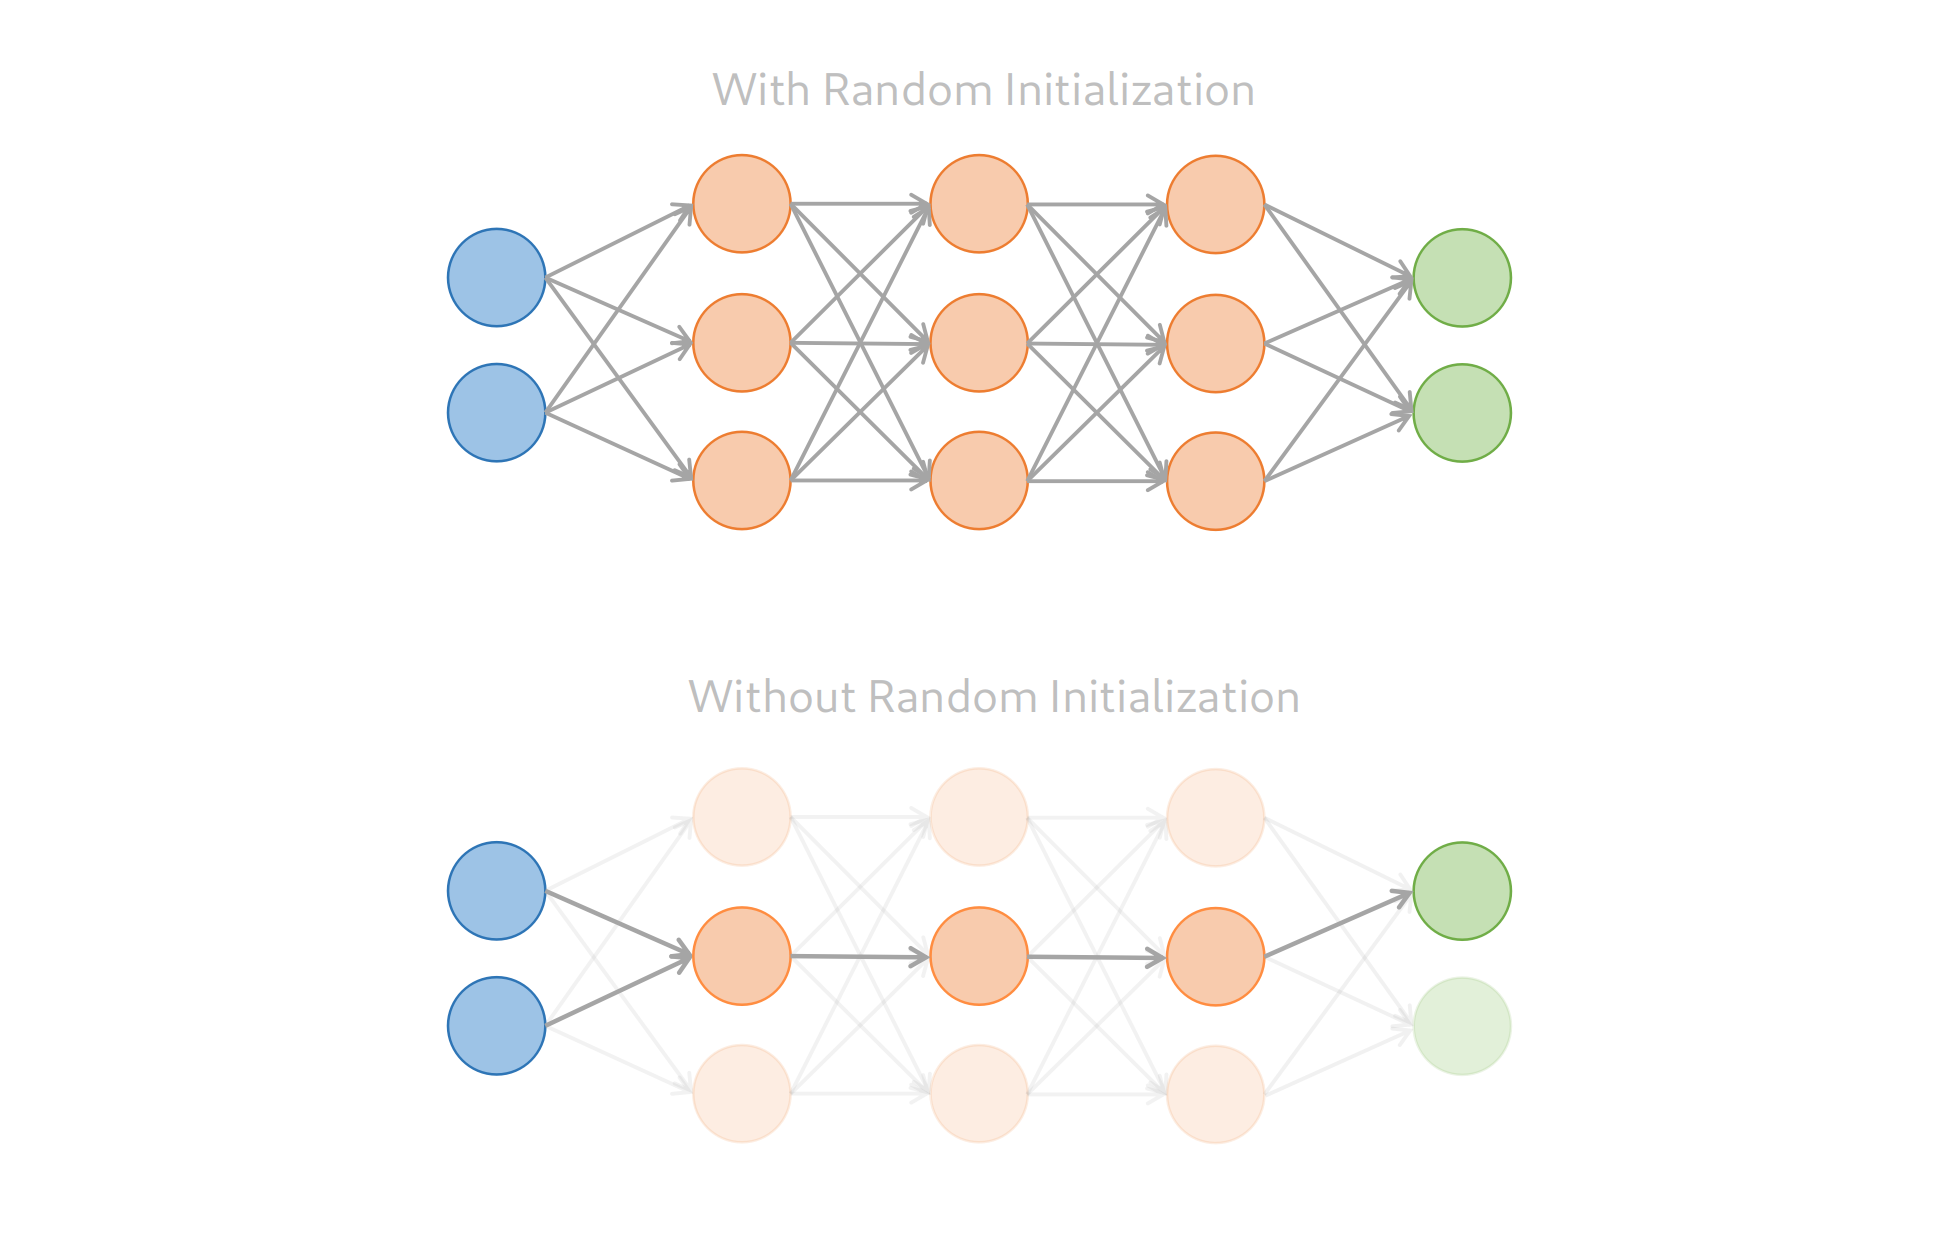



### Improved Weight Initialization
While random weight initialization is crucial for a functional Neural Netork, sometimes it may cause issues. Take a look at the cost graph down below:

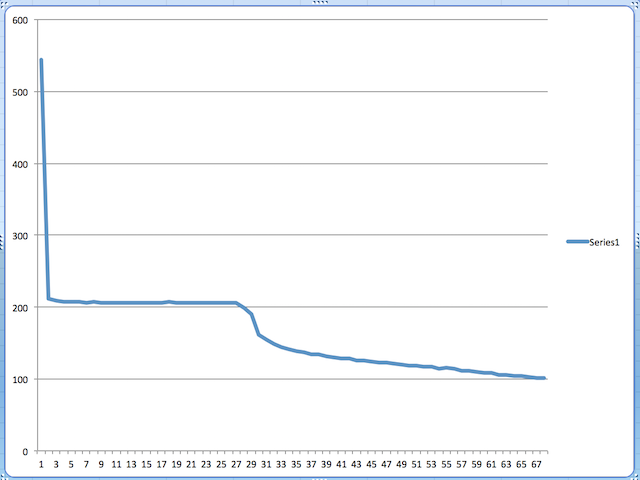

For the first 27 epochs, this Neural Network seemed like it was **not learning**, and then all of a sudden, it started learning again at epoch 29. These **slow start** scenarios are often due to poor weight initialization. While previously we chose 0.12 as the upper bound for random initialization, this number does not work well for all network architectures. We need an **adaptive, non-uniform** method of initializing weights.

This brings us to two different types of initialization methods: **Xavier Initialization** and **He Initialization**. These two methods are used to initialize weights for each layer of the NN, with **Xavier Initialization** used to initialize weights for layers with **Tanh** and **Sigmoid/Sofmax** activations, and **He Initialization** used for layers with **ReLU** activation.

In a moment, you'll get to see Xavier and He initialization in action in our **programming exercise**. For now, check out this link, where you'll get to see the importance of properly initializing your weights.

[https://www.deeplearning.ai/ai-notes/initialization/](https://www.deeplearning.ai/ai-notes/initialization/)

---

## Dropout <a name="dropout"></a>

In the previous topics, you learned about **overfitting** and **underfitting**, and how to address them. This is more important than ever when talking about Neural Networks. Since Neural Networks are able to **fit more complex relations**, it is **more prone to overfitting.** This is why over the years, computing scientists came up with more advanced methods of regulating the NN's weights and biases. 

### A New Form of Regularization <a name="newreg"></a>

So far, we've seen **L2 regularization** in action, smoothing out high degree polynomials so that they **generalize better**. While this works great for logistic regression, many times L2 regularization doesn't work as well for Neural Networks. That's not to say you *shouldn't* use L2, in fact more often you'll encounter NN's that use L2 than ones that do not. 

**Dropout** is a powerful method of regularization that often times work better than L2. It works by randomly turning off various neurons, which in turn results in a simpler network that is less prone to overfitting. In the figure below, notice how after every iteration, **a different set of neurons are turned off**.

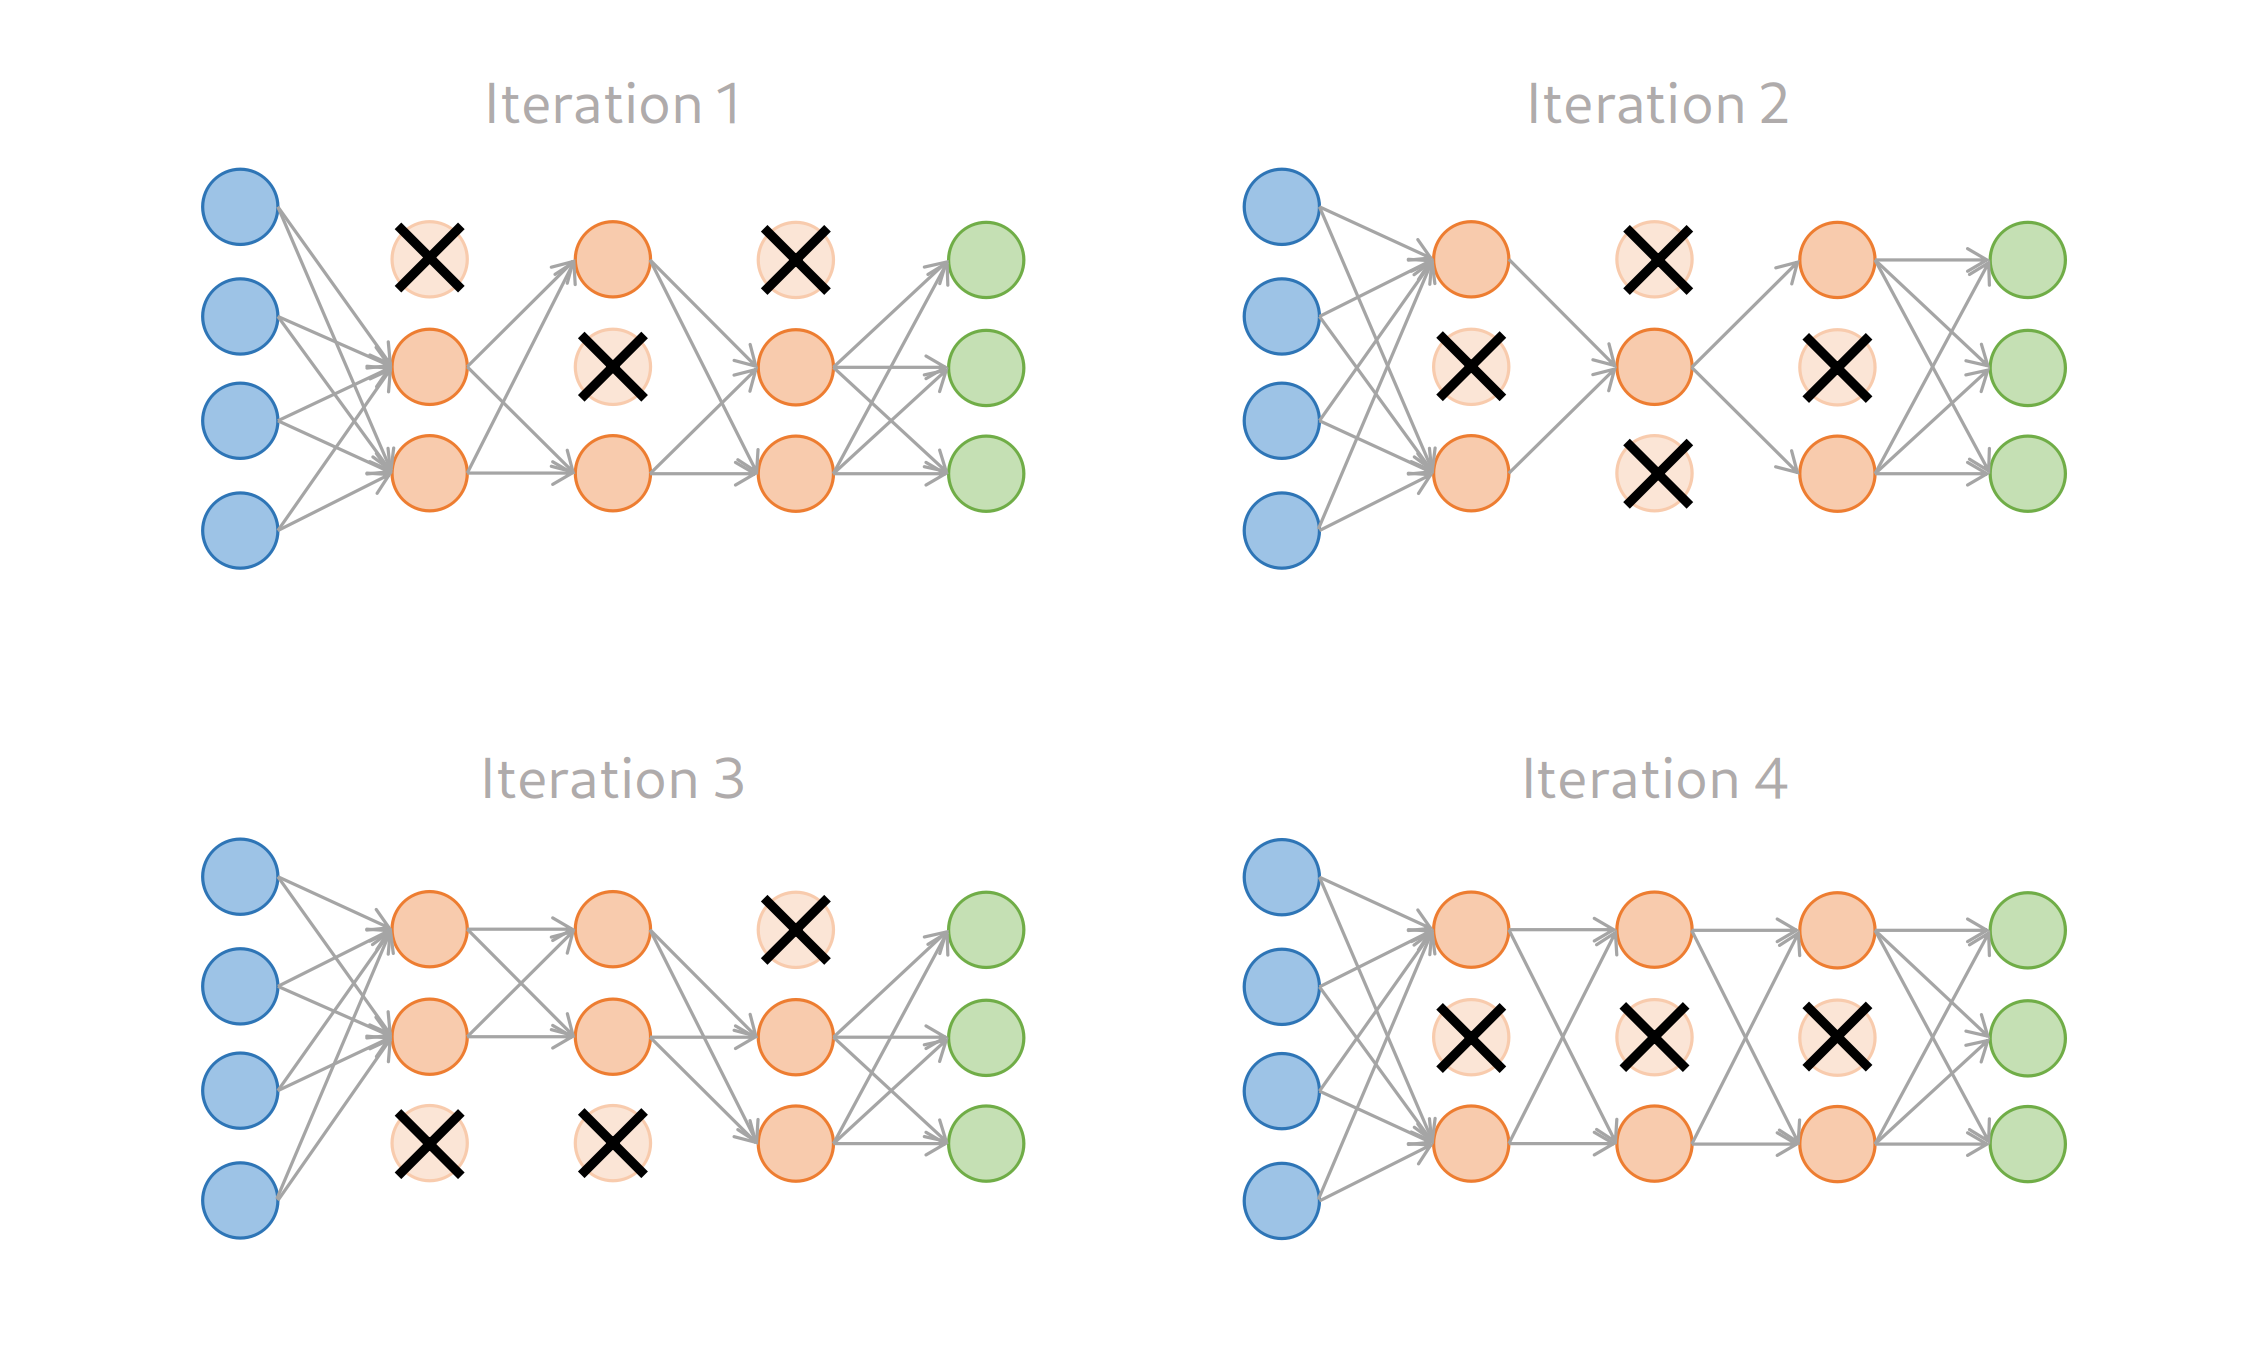

In addition to simplifying the network architecture, leading to less overfitting, dropout also **changes** the network architecture, so in short, your Neural Network could be fitting many different architectures to the problem.

### Implementation in PyTorch <a name="dppy"></a>

In PyTorch, L2 reglularization was implemented in the optimizer, meaning that the entire Neural Network had the same L2 regularization parameter. Dropout gives you more flexibility, as **each layer** will have its own dropout module. Dropout is implemented **after** the layer's activation function:

```python
def forward(self, x):
    x = self.z1(x)
    x = self.a1(x)
    x = Dropout(0.3)(x)
    
    x = self.z2(x)
    x = self.a2(x)
    x = Dropout(0.4)(x)
    
    x = self.z3(x)
    x = self.a3(x)
    x = Dropout(0.6)(x)
  
    x = self.z4(x)
    x = self.a4(x)
    
    return x
```

Here, we can pass a parameter into each dropout layer which represents the **probability** that a certain neuron is dropped. Notice that no dropout is applied to the output layer, as you do not want to randomly get rid of class predictions!

---

## Feature Scaling II <a name="feat2"></a>

Let's say that you trained a classifier to classify whether or not an image contains cats. Your training set contains 20000 images where the images labeled $y=1$ are images of **black cats**. Once you trained your classifier, you tested it on images containing **colored cats** and realize that your Neural Network performs poorly. This is no surprise -- after all, you did train the network on **black cats** and test them on **colored cats**. This phenomenon is called **Internal Covariate Shift**, and can hinder a Neural Network when training and testing conditions are not ideal.

### Batch Normalization <a name="batchnorm"></a>

In the previous topics, we talked about how feature scaling helps round out a cost function, making it much easier to traverse by gradient descent. We used **standard normalization** as the method of feature scaling, and scaled the features in the **input layer** before feeding it into the rest of the model.

Remember how we talked about Neural Networks being layers of Logistic Regression units **stacked** on top of each other? Turns out we can apply feature scaling to **each of the layers** within a Neural Network. This is called **Batch Normalization**, and can help significantly reduce Internal Covariate Shift.

A Neural Network with Batch Normalization can train **much faster**, and are less prone to overfitting because batch norm actually has some slight regularization effects. In fact, in the [original research paper on Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf), S. Ioffe and C. Szegedy mentioned that using batch norm will require less use of dropout and L2 regularization.

##### Question for the Students:
Why does **batch norm** allow for **faster training**? Think about how regular **feature scaling** worked to speed up training.

### Where to place Batch Norm <a name="where"></a>

Something you'll find on the internet that is often disagreed upon is **where** in the Neural Network Batch Normalization should be placed. There are generally **two** configurations of where batch norm is placed. Some people suggest ordering each layer of the Neural Network as `Linear` $\to$ `Activation` $\to$ `BatchNorm` $\to$ `Dropout`, whereas others suggest `Linear` $\to$ `BatchNorm` $\to$ `Activation` $\to$ `Dropout`. 

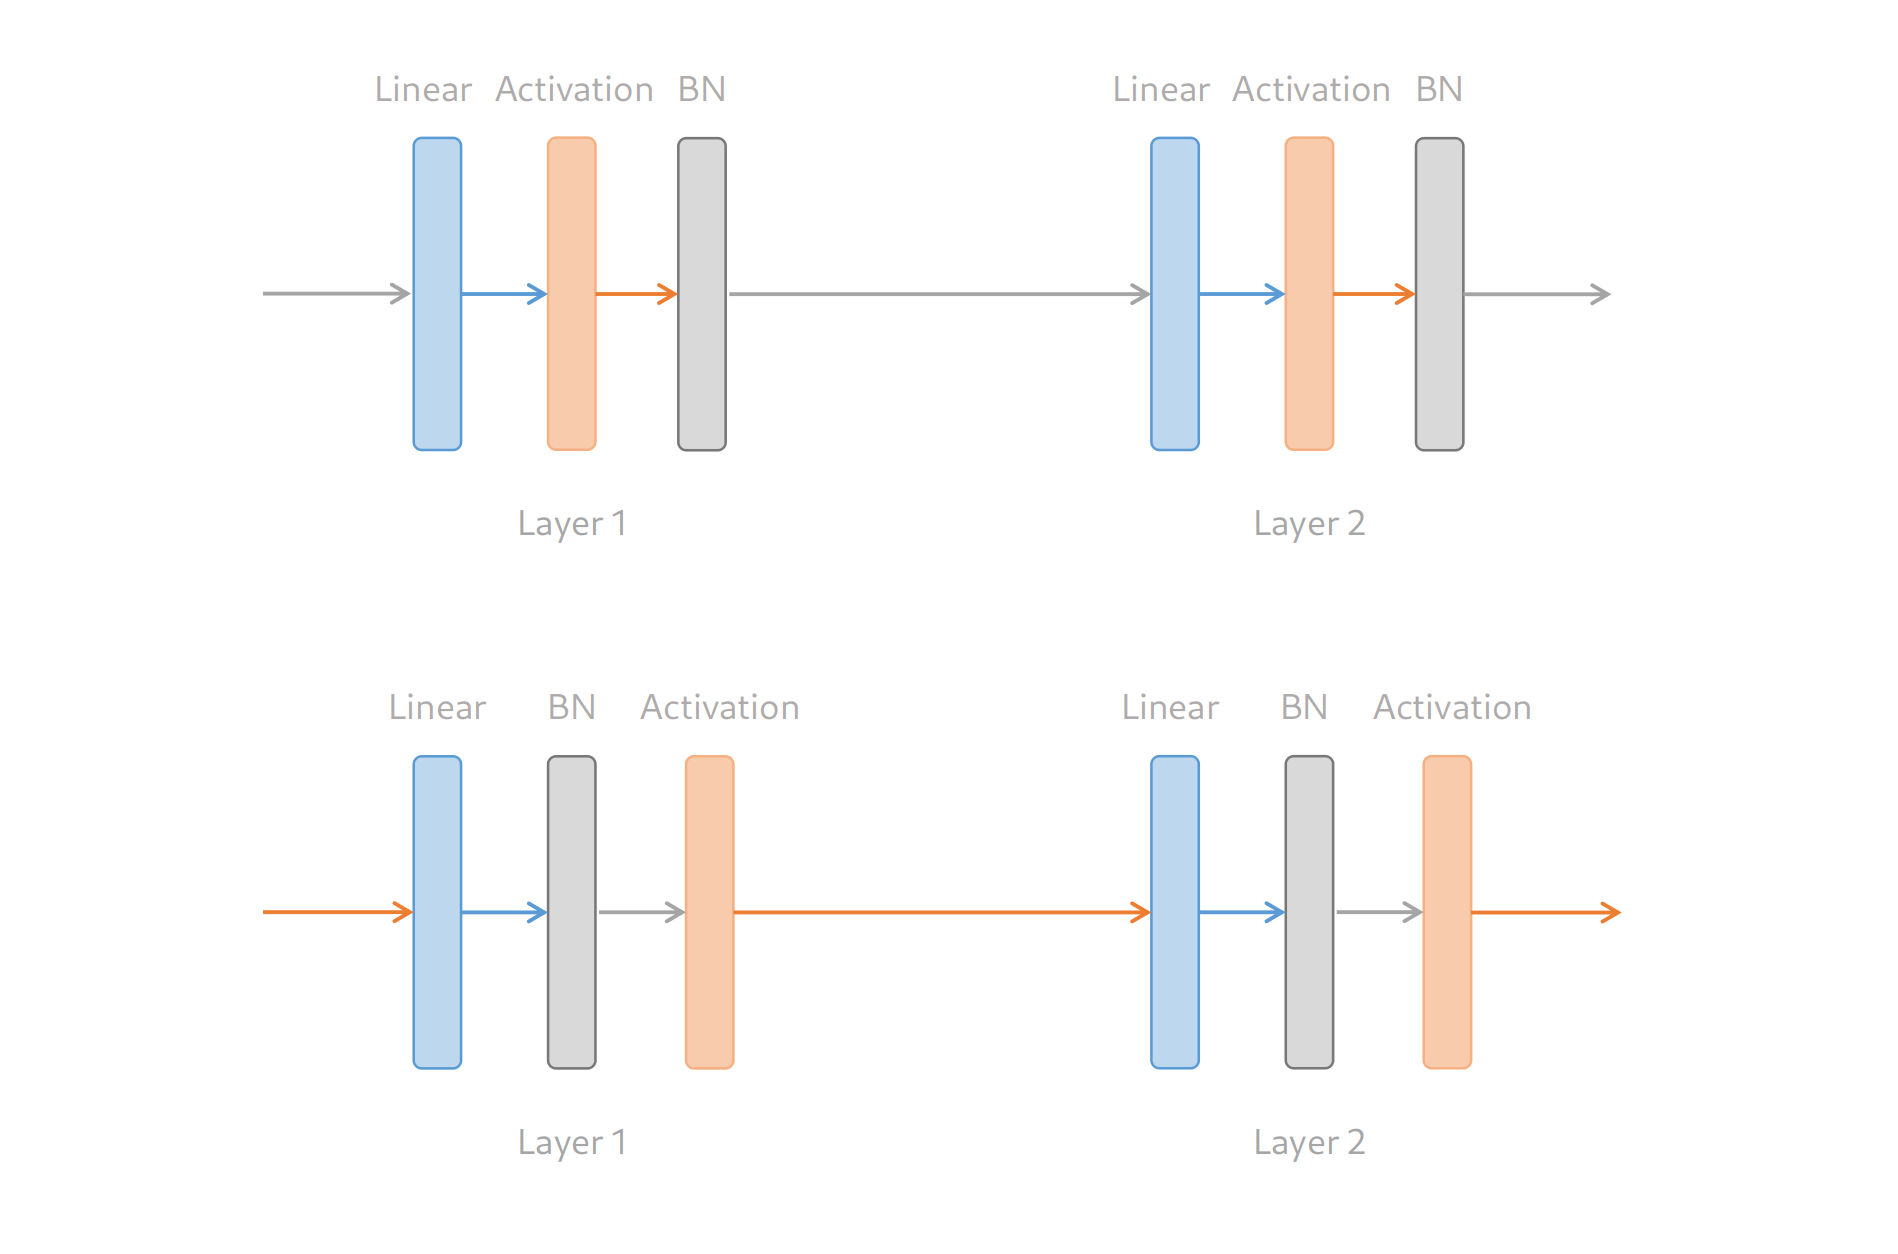

The original papers suggested that Batch Norm should be used **between the linear and activation layers**. This is because using it after the activation function usually **does not** eliminate **internal covariate shift**. Looking at the diagram shown above, the **second layout** is the layout we will use in our programming exercises.

---

## Optimizers <a name="optimizers"></a>

Up until now, we've seen how applying standard normalization to the input as well as batch normalization to each layer can help **round out** the cost function, making it **easier to traverse**. However, this is not always possible (with RNN, LSTM, etc. you cannot use batch norm), thus you are stuck trying to traverse a tricky cost function with gradient descent.

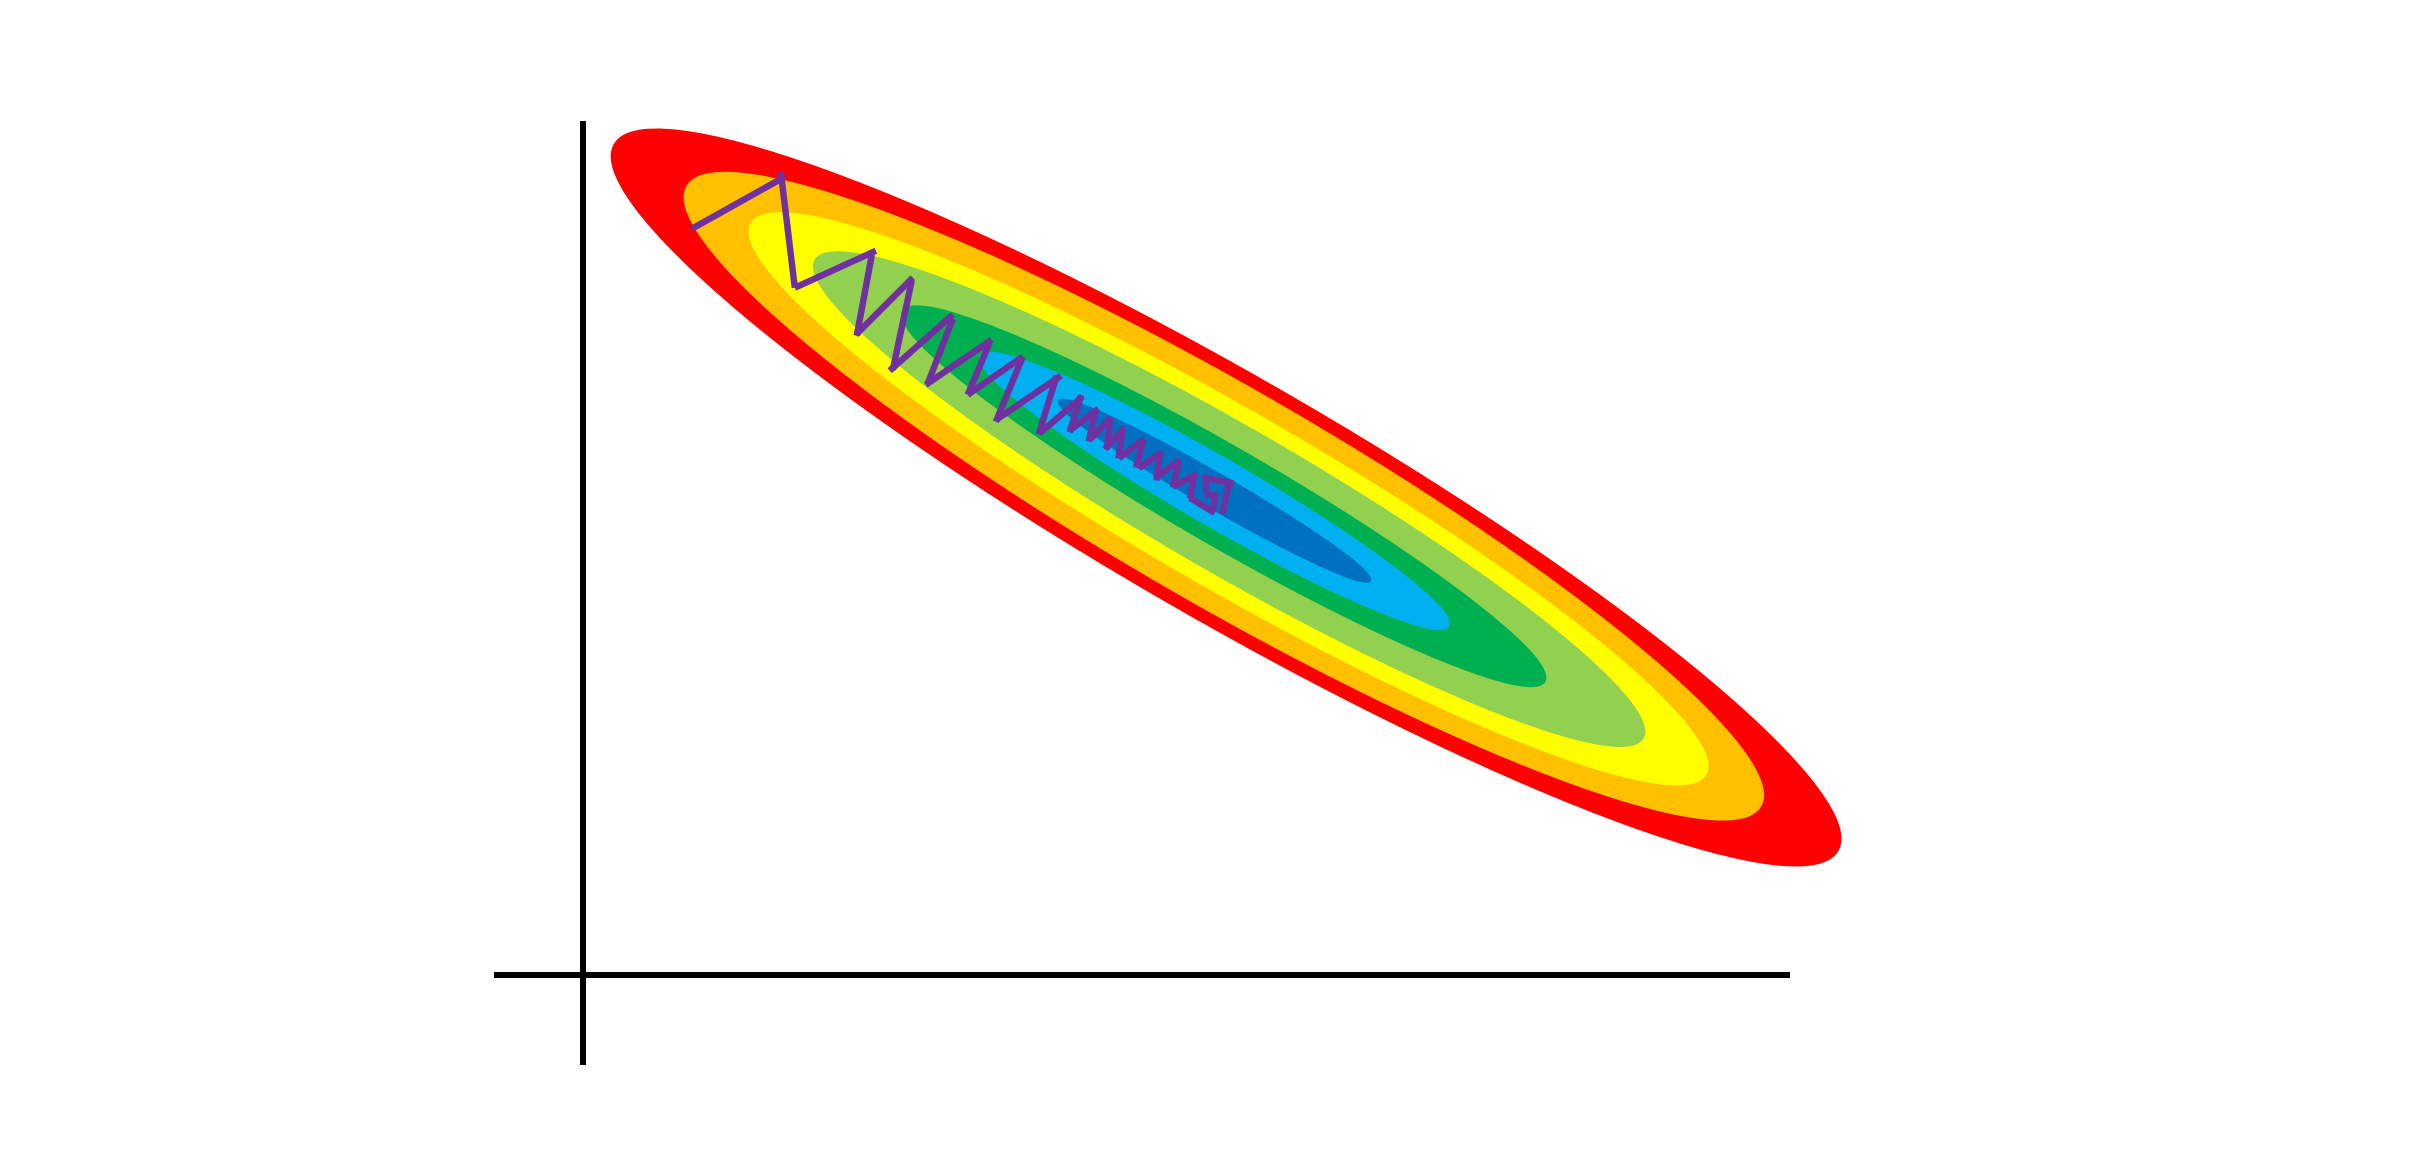

Here, notice how the descent from the long side of the cost function is very **unstable**. This is because gradient descent always moves in the direction of **steepest slope**, and mathematically speaking, that is always **perpendicular** to the contour lines. You can also think of setting a learning rate that is **high enough** to descend on the long side at a **reasonable pace**, however the learning rate is **too high** for the short side.

### Momentum <a name="momentum"></a>

Taking a look at the image above, we see many up and down **oscillations** that gradient descent took to reach the minimum. Note that the general trend is still from the top left down towards the center. Here's an idea to get rid of the oscillations: *What if we averaged across the last few steps?* By doing so, we will move **faster** in the general direction and the oscillations will be **reduced**.

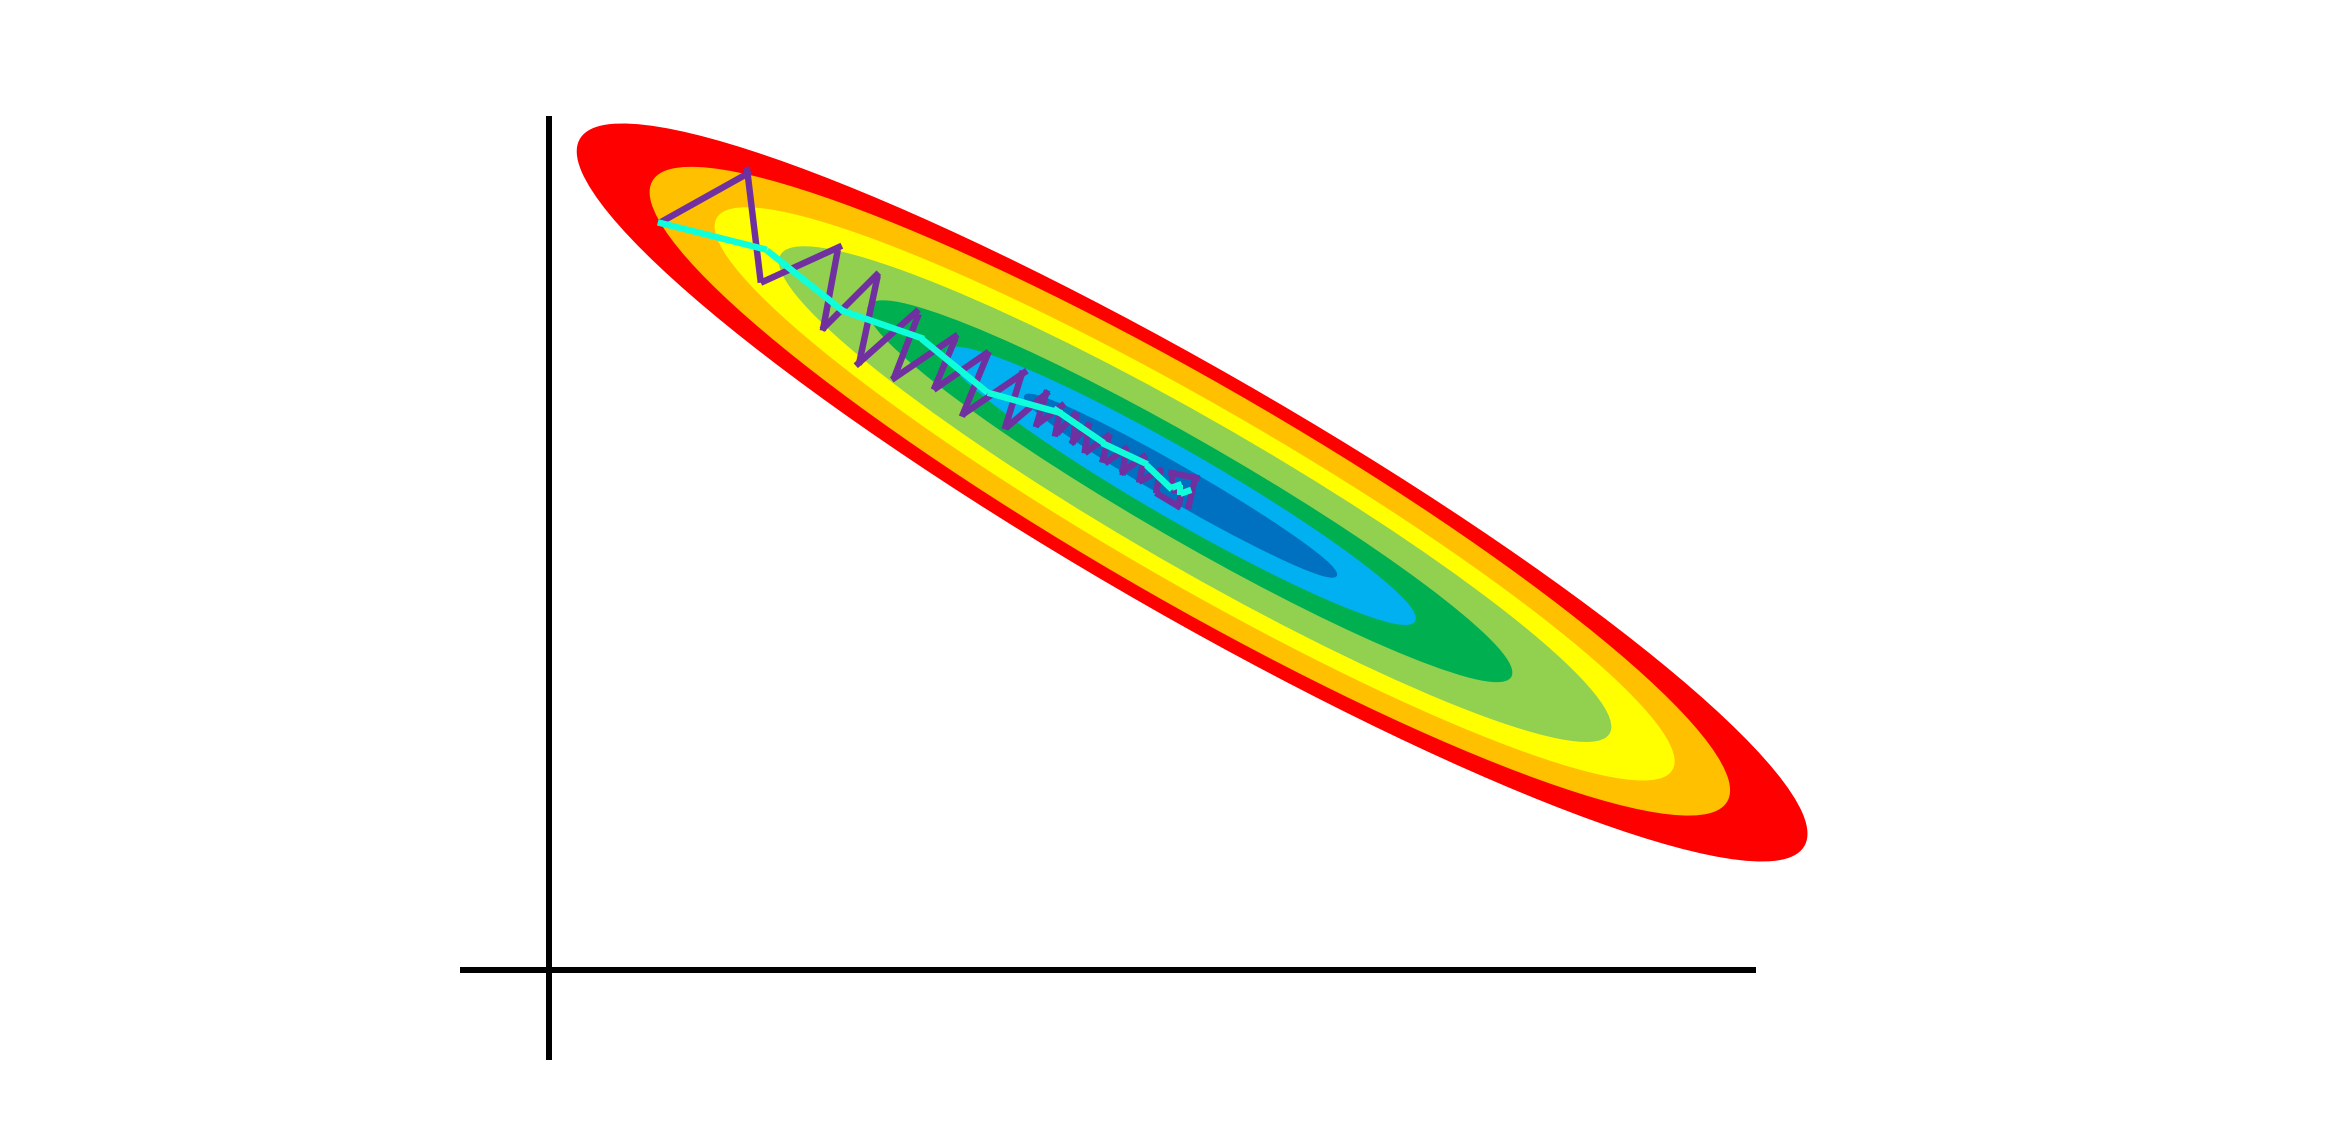

This brings us to the topic of various **advanced optimizers**, starting off with **momentum**. As you have seen in the picture above, momentum performs a new gradient step that is the **average** of many previous steps. This allows gradient descent to converge **much faster**, as less steps are needed to reach the optimum. Here's the implementation in PyTorch:

```python
import torch
from torch.optim import SGD

model = MyModelClass()

beta1 = 0.9
optimizer = SGD(model.parameters(), lr=0.01, momentum=beta1)

```

Notice how we specified the variable `beta1` for applying momentum. This value relates to **how many previous gradient steps we average across** for our next gradient step. We can define the number of previous steps averaged across by the following equation:

$$n = {1\over 1 - \beta_1} $$

Where:
- $n$ is the number of previous gradient steps to average across

In this case with $\beta_1 = 0.9$, we are averaging across the last 10 gradient steps. It is often recommended to use momentum with $\beta_1 = 0.9$.

### RMSprop <a name="rmsprop"></a>

RMSprop is another powerful optimizing algorithm that can **significantly speed up gradient descent** on sub-optimal cost functions. Just like momentum, **RMSProp** also makes gradient steps based on multiple previous steps. However, instead using the averages to accelerate gradient descent in the desired direction, RMSprop uses the squared averages to **dynamically scale the learning rate for each parameter** (no need to worry about squared averages for now). In other words, each $w$ and $b$ in your Neural Network will essentially have its own learning rate!

```python
import torch
from torch.optim import RMSprop

model = MyModelClass()

beta2 = 0.99
optimizer = RMSprop(model.parameters(), lr=0.01, alpha=beta2)

```

Here, RMSprop uses the hyperparameter`beta2`, which also describes how many previous squared gradients we are averaging across. The formula is identical from before, just replace $\beta_1$ with $\beta_2$. The recommended value is $\beta_2 = 0.99$, which corresponds with averaging across 100 gradient steps.

### Adam <a name="adam">

So far, we've talked about two advanced optimization algorithms. By averaging the previous gradients, momentum is able to **accelerate** gradient descent in the desired direction, and by averaging the previous squared gradients, RMSprop was able to **impede** oscillations in gradient descent.

**Adam** stands for **Ada**ptive **M**oment Estimation, where it performs the gradient steps by estimating **two moments** These two moments are **Momentum** and **RMSprop**! In short, Adam is a combination of Momentum and RMSprop! This produces a ridiculously fast converging optimization algorithm. From now on, it is recommended that you use Adam instead of SGD for the choice of optimizer. In literature, the authors D. Kingma and J. Ba of the [original paper on Adam](https://arxiv.org/pdf/1412.6980.pdf) suggested $\beta_1 = 0.9$ and $\beta_2 = 0.999$, corresponding to the coefficients for momentum and RMSprop

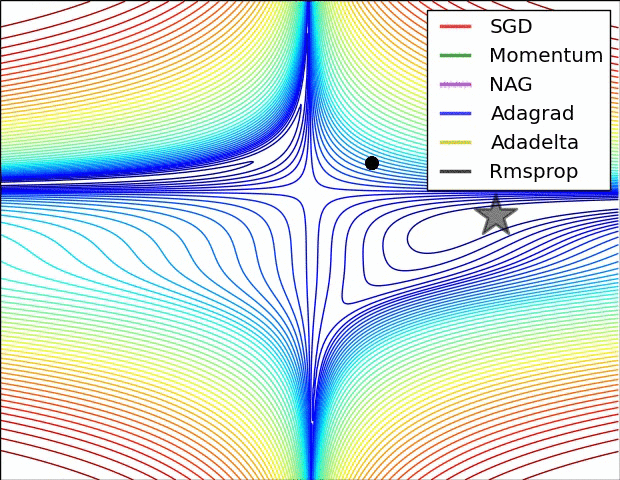

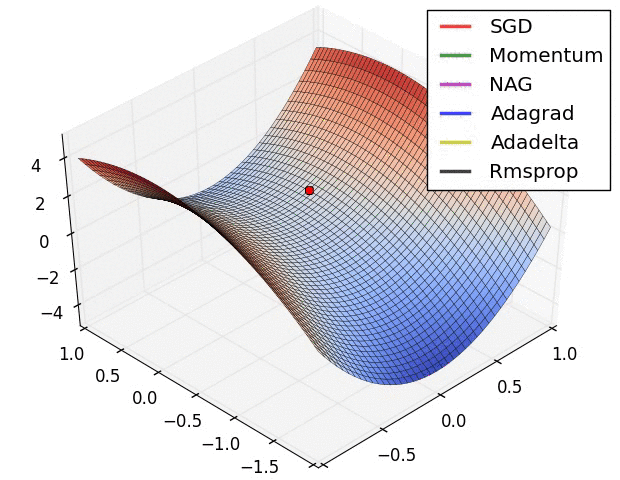


Here, you see comparisons between various optimization algorithms. Notice that momentum as well as RMSprop are both much quicker than vanilla SGD, which was what we were using before. At the time these Gifs were made, Adam was not developed yet, however in the papers on Adam, the authors showed that it was indeed **faster than AdaDelta**.

---

## Hyperparameter Search <a name="hparams"></a>

Previously, we learned how developing machine learning models is an **iterative process**, requiring us to search for the optimal hyperparameters. We also learned how to interpret cost plots between the training set and cross validation sets, as well as understanding secondary metrics such as Accuracy, R2, F1, etc. We also played a **hyperparameter search game**, where all students would pick random hyperparameter values to try, and the student with the highest accuracy score would "pass down" their hyperparameters to the next batch. Our goal for this topic is to **automate** that process (somewhat).

### The General Idea <a name="idea"></a>

We are going to create a bunch of models, with each model having a different set of hyperparameters, and testing all the models, seeing which one has the highest validation accuracy. Then, we are going to repeat the process, this time using hyperparameters that are much closer to the winning model.

### Grid Search <a name="grid"></a>

**Grid search** is an exhaustive search algorithm that tries every possible combination of hyperparameters. In the example below, we initialize three random **learning rates** between $10^{-8}$ and $10^{-2}$, three random **L2 constants** between $10^{-10}$ and $10^{-1}$, and 3 random **dropout values** between $0$ and $1$.

```python

# randomly generating three of each hyperparameter
LEARNING_RATE = 10**np.random.uniform(-8, -2, 3)
L2 = 10**np.random.uniform(-10, -1, 3)
DROP = np.random.uniform(0, 1, 3)

# GRID SEARCH
for lr in LEARNING_RATE:
    for l2 in L2:
        for drop in DROP:
            
            model = New_Model(lr, l2, drop)
            model.fit()
```

While on first thought searching through all combinations of hyperparameters is good, however **grid search is a terrible method of hyperparameter search**. This is because while in the example above we looped through 27 combinations of hyperparameters, we have only effectively tested out **three** different values of learning rate, L2, and dropout. The diagram below shows grid search with just two hyperparameters: learning rate and L2. 

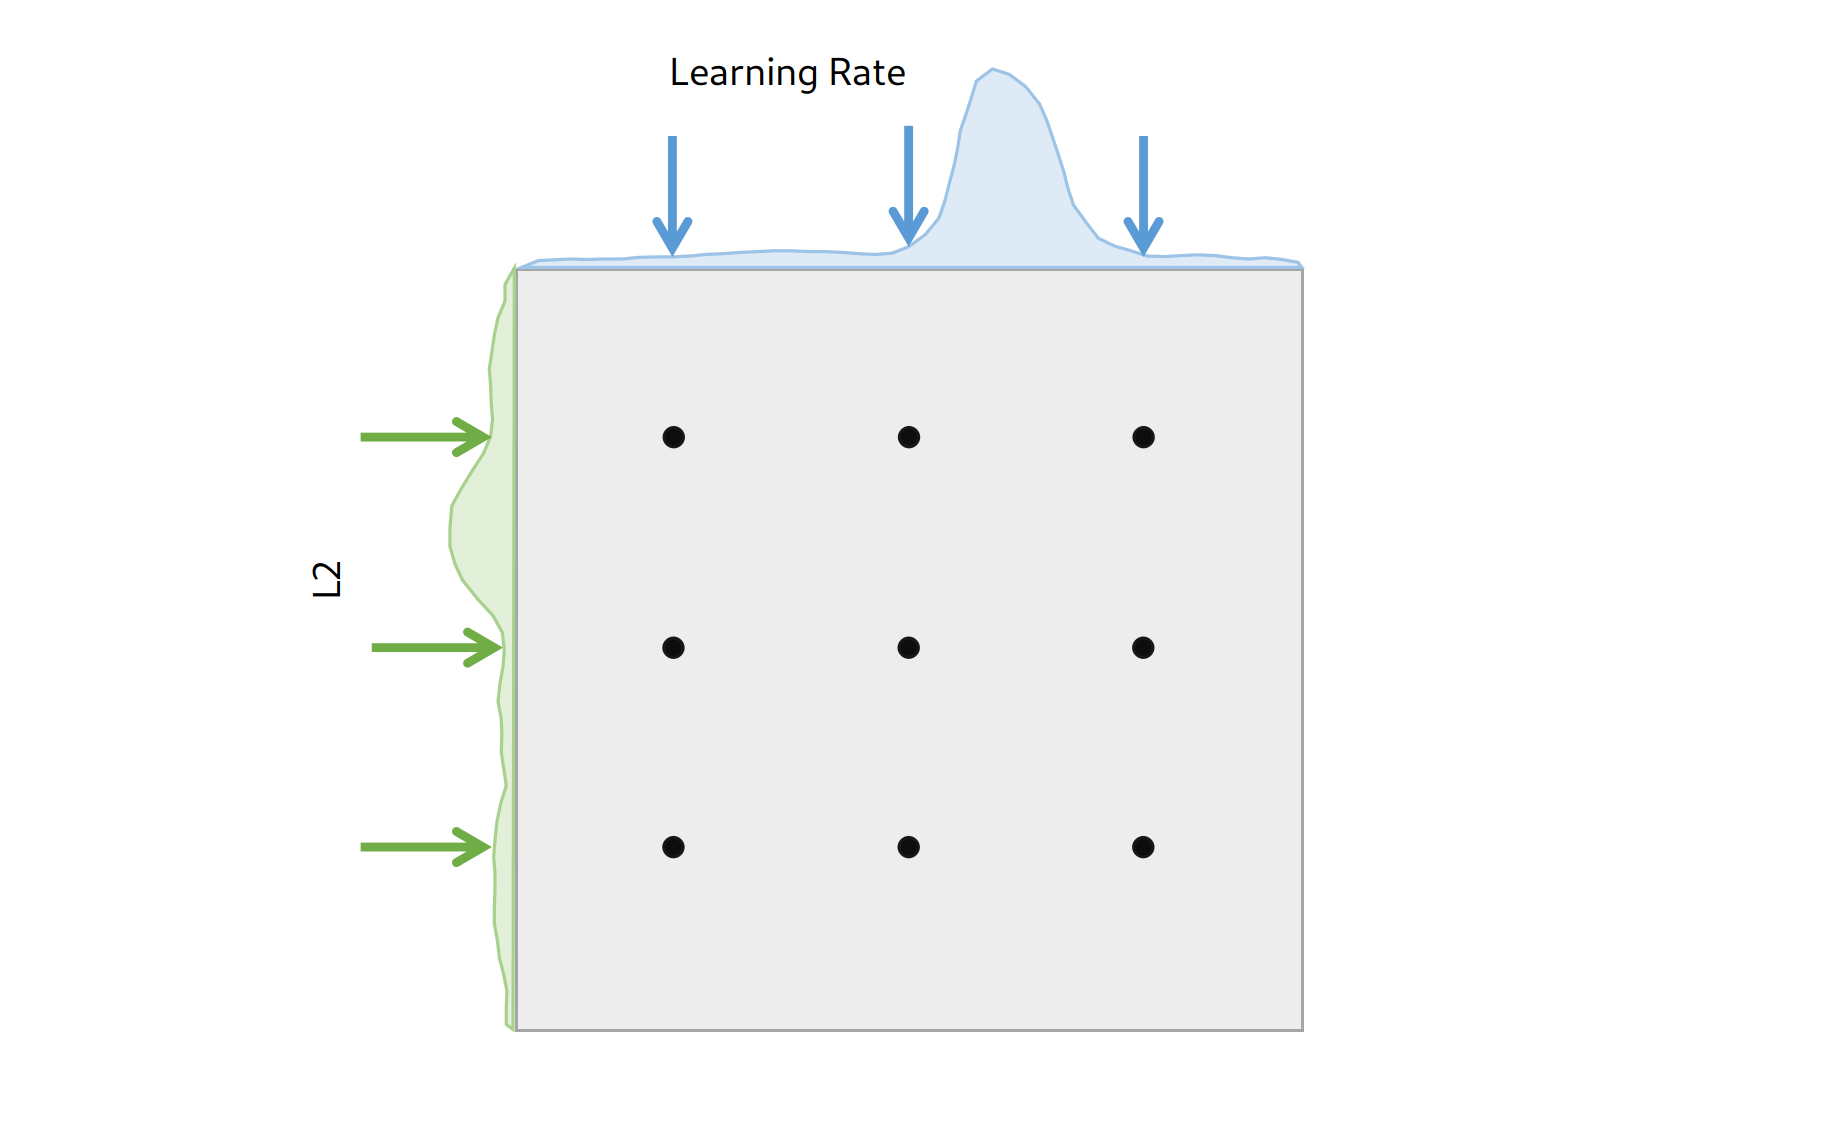

Looking at the diagram above, you can see that grid search literally looks like a grid, that that is the **main problem**! Out of the 9 combinations of hyperparameters tried, you have only tried 3 different learning rates and 3 different regularization values.

When searching for hyperparameters, you'll find that some hyperparameters have a **very large effect on the performance of the NN**, whereas others do not. Here, you can see that Learning Rate has a **large impact** on the performance of the model, as signified by the tall "hump", whereas L2 doesn't have as big of an impact on the performance of the model. Using grid search in this example happened to **miss both of the humps**, thus further slowing down the hyperparameter search process.



### Random Search <a name="random"></a>

**Random search** solves the problem of grid search by **randomly generating a new set of hyperparameters for every model**. Random search no longer loops through all combinations of hyperparameters. Let's recreate the previous code example where we create **27 models**, but this time using random search.

```python
# randomly generating 27 of each hyperparameter
LR = 10**np.random.uniform(-8, -2, 27)
L2 = 10**np.random.uniform(-10, -1, 27)
DROP = np.random.uniform(0, 1, 27)

# RANDOM SEARCH
for i in range(27):
    model = New_Model(LR[i], L2[i], DROP[i])
    model.fit()
```

Random search is so much better than grid search because you are effectively testing 27 different values of learning rate, L2, and dropout. Down below is the illustration of random search using only learning rate and L2. Once again, just like last time, we will create 9 models.

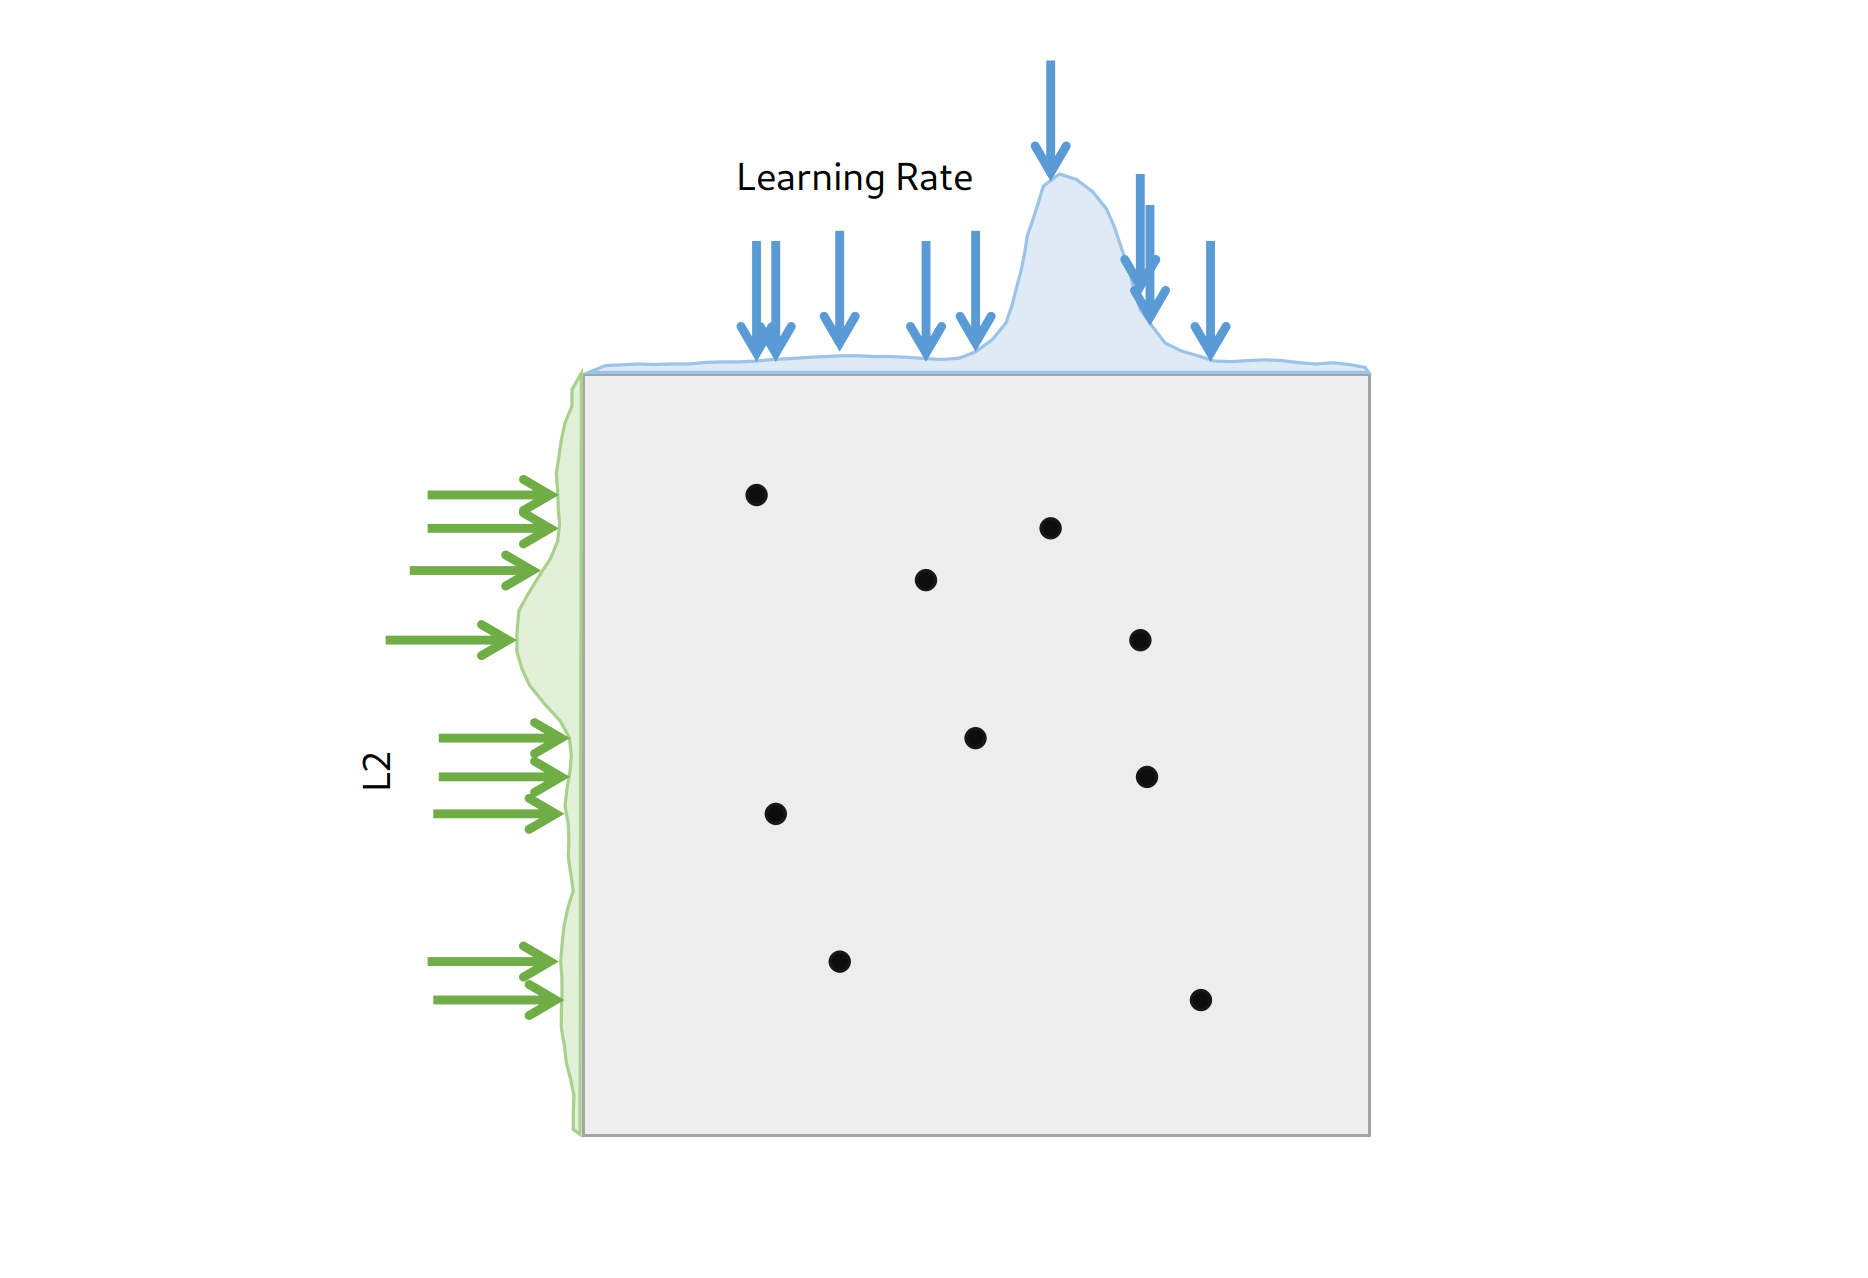

Using random search, we are able to cover 9 different learning rate values as well as 9 regularization values, hence this is a much better solution than grid search. Also note that this time, we were able to find the optimal learning rate and L2 values relatively easily.

## $\mathcal{Fin}$

Congrats on making it to the end of Topic 5! For our next activity, we'll take what we've learned in this class and apply it in PyTorch. See you in Google Colab!

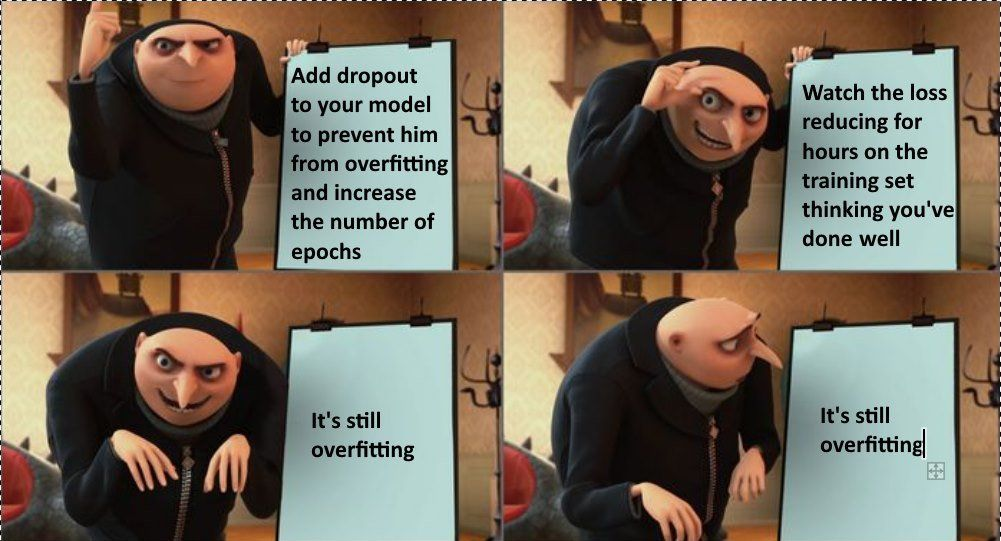

## References
- [https://ruder.io/optimizing-gradient-descent/index.html#rmsprop](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop)
- [[https://www.deeplearning.ai/ai-notes/initialization/](https://www.deeplearning.ai/ai-notes/initialization/)]([https://www.deeplearning.ai/ai-notes/initialization/](https://www.deeplearning.ai/ai-notes/initialization/))